In [1]:
import dill
dill.load_session('working_model.db')

C:\Users\maste\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def dataFrameCreatorCSV(file):
    cols = ['handle','keyword','body','date_tweeted','replies','likes', 'retweets']
    tweet_df = pd.read_csv(file, header=None, names=cols ,encoding = 'latin-1')
    tweet_df.drop(['handle','keyword','replies','likes', 'retweets'],axis=1,inplace=True)
    tweet_df = cleanDF(tweet_df)
    return tweet_df

In [3]:
import json
def dataFrameCreatorJSON(file):
    with open(file, 'rb') as f:
        data = json.load(f)
    tweet_df = pd.DataFrame(data)
    tweet_df.drop(['TweetKeyword','TweetHandle','TweetReplies','TweetRetweets','TweetLikes'],axis=1,inplace=True)
    tweet_df.columns = ['date_tweeted','body']
    tweet_df = cleanDF(tweet_df)
    return tweet_df

In [4]:
def reformData(name): 
    name['sentiment'] = sentimentTweet(name)#generates new column of sentiments using the seniment tweet method
    name['predNum'] = sentimentTweetNum(name)#generates new column of predNum using the sentiment tweet num method(decision function)
    name['prediction'] = sentimentTweetPre(name)#generates new column of sentiments using the prediction call from svm
    return name #returns dataframe

In [5]:
def sentimentTweet(name):
    text  = name.body
    x2 = vect.transform(text) #uses the tf-idf to transform the tweets so the model can use to predict
    db = svm_clf.decision_function(x2) #calls the decision funtion on all of the tweets in given dataframe
    db = db.astype(object)
    for i in range(len(db)): #Using the decision function splits each sentiment prediction into either positive, negative,or neutral
        if db[i] > 0.275:
            db[i]= "positive"
        elif db[i] < 0.275 and db[i] > -0.275:
            db[i]="neutral"
        elif db[i] < -0.275:
            db[i] = "negative"
        else:
            print("not real")
    return db


In [6]:
def sentimentTweetNum(name):
    text  = name.body
    x2 = vect.transform(text) #uses the tf-idf to transform the tweets so the model can use to predict
    db = svm_clf.decision_function(x2)#calls the decision funtion on all of the tweets in given dataframe
    return db #returns the decision function values -4 - 4

In [7]:
def sentimentTweetPre(name):
    text  = name.body
    x2 = vect.transform(text) #uses the tf-idf to transform the tweets so the model can use to predict
    db = svm_clf.predict(x2) #uses the linear svm models predict function to generate predictions of 1 or 0
    return db #returns the predicted sentiments

In [8]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(body):
    soup = BeautifulSoup(body, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [9]:
def tweetDataCleaner(df):
    nums = [0,len(df)]
    print ("Cleaning and parsing the tweets...\n")
    clean_tweet_texts = [] #initializes an empty array for cleaned tweets
    for i in range(nums[0],nums[1]): #for loop through first all the way to the length of the dataframe
        if( (i+1)%10000 == 0 ):
            print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
        clean_tweet_texts.append(tweet_cleaner(df['body'][i]))#appends the now clean tweets into the dataframe
    return clean_tweet_texts #returns cleaned tweets

In [10]:
def cleanDF(name):
    clean_df = pd.DataFrame(tweetDataCleaner(name),columns=['body']) # calls the tweet cleaner caller 
    clean_df['date'] = name.date_tweeted #generates a date column for each tweet
    return clean_df

In [11]:
%%time 
# counts the total wall time of the call
twitterData = dataFrameCreatorJSON('tesla.JSON')
# calls and creates dataframe of  tweets.

Cleaning and parsing the tweets...

Tweets 10000 of 42320 has been processed
Tweets 20000 of 42320 has been processed
Tweets 30000 of 42320 has been processed
Tweets 40000 of 42320 has been processed
Wall time: 24.1 s


In [12]:
twitterData.head() # returns the first five tweets

,body,date
0,makes reno critical stop on way to,2016-12-30T00:00:00.000Z
1,nikola tesla invented time machine and ran mul...,2016-12-30T00:00:00.000Z
2,had dream that kyra got tesla and then crashed it,2016-12-30T00:00:00.000Z
3,our most read electric car review on autocar b...,2016-12-30T00:00:00.000Z
4,in kawakawa you can watch tesla charging while...,2016-12-30T00:00:00.000Z


In [13]:
%%time 
# calculates the run time of the reformData method when applied to  dataframe
twitterData = reformData(twitterData)

Wall time: 16.3 s


In [14]:
twitterData.set_index(pd.DatetimeIndex(twitterData['date']).normalize(), inplace=True) #sets the index of every item in dataframe to the date

In [15]:
twitterData.sort_index() # sorts the index from earlies to latest
twitterData.head() # returns the first five tweets

,body,date,sentiment,predNum,prediction
date,,,,,
2016-12-30,makes reno critical stop on way to,2016-12-30T00:00:00.000Z,neutral,0.197893,4
2016-12-30,nikola tesla invented time machine and ran mul...,2016-12-30T00:00:00.000Z,neutral,-0.141519,0
2016-12-30,had dream that kyra got tesla and then crashed it,2016-12-30T00:00:00.000Z,negative,-0.558637,0
2016-12-30,our most read electric car review on autocar b...,2016-12-30T00:00:00.000Z,positive,0.719384,4
2016-12-30,in kawakawa you can watch tesla charging while...,2016-12-30T00:00:00.000Z,positive,0.785259,4


In [16]:
twitterData.groupby(twitterData.index).head().sentiment.value_counts() #returns the sentiment value counts of the first five tweets

positive    1032
neutral      545
negative     253
Name: sentiment, dtype: int64

In [17]:
twitterData.groupby(twitterData.index).sentiment.value_counts()# returns a count for each day in index of each column so 320 body means 320 tweets for that day

date        sentiment
2016-12-30  positive      30
            neutral       20
            negative       9
2016-12-31  positive      30
            neutral       22
            negative      16
2017-01-01  positive      44
            neutral       24
            negative       9
2017-01-02  positive      63
            neutral       27
            negative      15
2017-01-03  positive      52
            neutral       36
            negative      34
2017-01-04  positive     124
            neutral       64
            negative      44
2017-01-05  positive      91
            neutral       40
            negative      18
2017-01-06  positive      60
            neutral       19
            negative      13
2017-01-07  positive      37
            neutral       18
            negative      14
2017-01-08  positive      46
            neutral       17
            negative       5
                        ... 
2017-12-21  positive      81
            neutral       33
            negative 

In [18]:
twitterData.info() #returns the info of the dataframe

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42320 entries, 2016-12-30 to 2017-12-30
Data columns (total 5 columns):
body          42320 non-null object
date          42320 non-null object
sentiment     42320 non-null object
predNum       42320 non-null float64
prediction    42320 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [19]:
# csv = 'finalStockAMZN.csv' 
csv = 'finalStockTSLA10.csv' 
# csv = 'finalStockAAPL15.csv' 
# calling the saved stock file made in the stock class
Stock = pd.read_csv(csv,index_col=0)
Stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1414 entries, 2015-01-03 to 2018-11-16
Data columns (total 3 columns):
close          1414 non-null float64
pctChange      1414 non-null float64
StockChange    1414 non-null object
dtypes: float64(2), object(1)
memory usage: 44.2+ KB


In [20]:
Stock.sort_index()
Stock.head(20)#stock of twitterData stock pct change

,close,pctChange,StockChange
2015-01-03,216.236667,-0.014014,decrease
2015-01-04,213.163333,-0.014213,decrease
2015-01-05,210.090000,-0.014418,decrease
2015-01-06,211.280000,0.005664,neutral
2015-01-07,210.950000,-0.001562,neutral
2015-01-08,210.615000,-0.001588,neutral
2015-01-09,206.660000,-0.018778,decrease
2015-01-10,205.176667,-0.007178,neutral
2015-01-11,203.693333,-0.007230,neutral
2015-01-12,202.210000,-0.007282,neutral


In [21]:
Stock.StockChange.value_counts()#stock closing price

neutral     786
positive    328
decrease    300
Name: StockChange, dtype: int64

In [22]:
twitterData = twitterData.merge(Stock,left_index=True, right_index=True)
# #merging all stock dataframes with twitterData dataframe by date

In [23]:
twitterData.head()

,body,date,sentiment,predNum,prediction,close,pctChange,StockChange
2016-12-30,makes reno critical stop on way to,2016-12-30T00:00:00.000Z,neutral,0.197893,4,213.69,-0.004612,neutral
2016-12-30,nikola tesla invented time machine and ran mul...,2016-12-30T00:00:00.000Z,neutral,-0.141519,0,213.69,-0.004612,neutral
2016-12-30,had dream that kyra got tesla and then crashed it,2016-12-30T00:00:00.000Z,negative,-0.558637,0,213.69,-0.004612,neutral
2016-12-30,our most read electric car review on autocar b...,2016-12-30T00:00:00.000Z,positive,0.719384,4,213.69,-0.004612,neutral
2016-12-30,in kawakawa you can watch tesla charging while...,2016-12-30T00:00:00.000Z,positive,0.785259,4,213.69,-0.004612,neutral


In [24]:
twitterData.columns = ['body','date','sentiment','predNum','prediction','price','pricePCTch','Change']#changing column headers of twitterData
twitterData = twitterData.replace(['positive','neutral','decrease', 'negative'],[1,0,-1,-1])#replacing all names of negative positive and neutral with 1,0,-1
twitterData.Change.value_counts()

 0    23735
 1    10906
-1     7679
Name: Change, dtype: int64

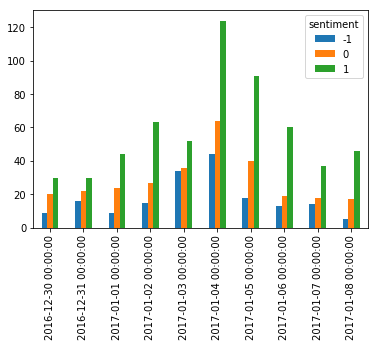

In [25]:
twitterData.groupby(twitterData.index).sentiment.value_counts().head(30).unstack().plot.bar()
#plotting ddaily sentiment amounts for first 10 days

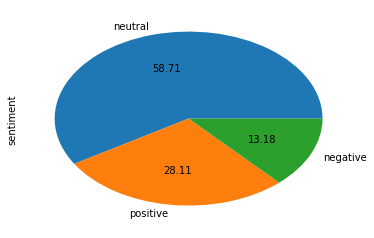

In [26]:
twitterData.sentiment.value_counts().plot.pie(labels=['neutral','positive','negative'],autopct='%.2f')
#showing sentimennt percents for whole dataframe

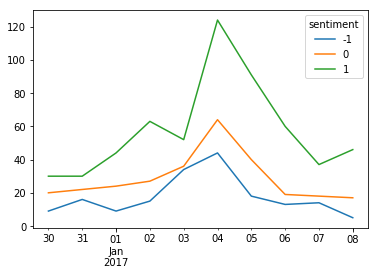

In [27]:
twitterData.groupby(twitterData.index).sentiment.value_counts().head(30).unstack().plot()
#plotting line graph of sentiments by day

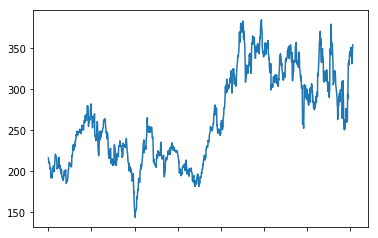

In [28]:
Stock.close.plot()
plt.show()
#closing prices of the stock plotted

In [29]:
twitterData.sort_index()#sorting index by date
twitterData.head()

,body,date,sentiment,predNum,prediction,price,pricePCTch,Change
2016-12-30,makes reno critical stop on way to,2016-12-30T00:00:00.000Z,0,0.197893,4,213.69,-0.004612,0
2016-12-30,nikola tesla invented time machine and ran mul...,2016-12-30T00:00:00.000Z,0,-0.141519,0,213.69,-0.004612,0
2016-12-30,had dream that kyra got tesla and then crashed it,2016-12-30T00:00:00.000Z,-1,-0.558637,0,213.69,-0.004612,0
2016-12-30,our most read electric car review on autocar b...,2016-12-30T00:00:00.000Z,1,0.719384,4,213.69,-0.004612,0
2016-12-30,in kawakawa you can watch tesla charging while...,2016-12-30T00:00:00.000Z,1,0.785259,4,213.69,-0.004612,0


In [30]:
twitterData.sentiment.value_counts()

 1    24848
 0    11895
-1     5577
Name: sentiment, dtype: int64

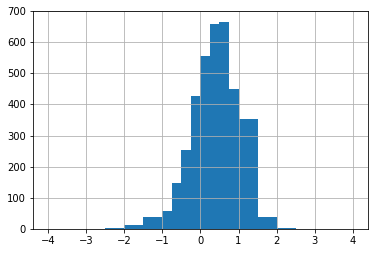

In [31]:
twitterData.groupby(twitterData.index).head(10).predNum.hist(bins=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4])
# HISTOGRAM OF SENTIMENT
#use histogram to predict  price by each bin being a feature

In [32]:
binSize= pd.DataFrame(twitterData.groupby(twitterData.index).predNum.value_counts(bins=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4], sort=False))
#placing each days bins in a dataframe

In [33]:
#Server=tcp:feels.database.windows.net,1433;Initial Catalog=twitter;Persist Security Info=False;User ID=NYIT;Password=Pineapple!;MultipleActiveResultSets=False;Encrypt=True;TrustServerCertificate=False;Connection Timeout=30;

In [34]:
binSize.columns = ['predNumAmmount']#renaming columns to predNumAmmount

In [35]:
newBin = pd.DataFrame(binSize['predNumAmmount'])
newBin = newBin.reset_index()
newBin = newBin.pivot(index='level_0', columns='predNum', values='predNumAmmount')
#reset index and pivot dataframe to make it easier to work with

In [36]:
newBin.sort_index()
newBin.index.name = None
newBin.columns.name = None
newBin.columns = ['(-4.001, -3.5]','(-3.5, -3.0]','(-3.0, -2.5]','(-2.5, -2.0',
                '(-2.0, -1.5]','(-1.5, -1.0]','(-1.0, -0.75]','(-0.75, -0.5]','(-0.5, -0.25]',
                                   '(-0.25, 0.0]','(0.0, 0.25]','(0.25, 0.5]','(0.5, 0.75]','(0.75, 1.0]','(1.0, 1.5]',
                                   '(1.5, 2.0]','(2.0, 2.5]','(2.5, 3.0]','(3.0, 3.5]','(3.5, 4.0]']
#renaming the columns and cleaning the dataframe

In [37]:
twitterDataMean = twitterData.groupby(twitterData.index).mean()
#creates a dataframe of the mean values of twitterData

In [38]:
twitterDataMax =  twitterData.groupby(twitterData.index).max()
#creates a dataframe of the max values of twitterData

In [39]:
twitterDataMin =  twitterData.groupby(twitterData.index).min()
#creates a dataframe of the min values of twitterData

In [40]:
twitterDataMedian =  twitterData.groupby(twitterData.index).median()
#creates a dataframe of the median values of twitterData

In [41]:
twitterData['averageSentiment']= twitterDataMean['predNum']
#creates new column in twitterData dataframe using twitterData mean value of predNum

In [42]:
twitterData = twitterData.merge(newBin,left_index=True, right_index=True)
#merge twitterData with newBin dataframe

In [43]:
twitterDataMean= twitterDataMean.merge(newBin,left_index=True, right_index=True)
twitterDataMean['maxPred'] = twitterDataMax['predNum']
twitterDataMean['minPred'] = twitterDataMin['predNum']
twitterDataMean['range'] = twitterDataMax['predNum']-twitterDataMin['predNum']
twitterDataMean['STD'] = twitterData.groupby(twitterData.index).predNum.std().fillna(method='ffill')
#create new columns in twitterDataMean for features

In [44]:
twitterData['maxPred'] = twitterDataMax['predNum']
twitterData['minPred'] = twitterDataMin['predNum']
twitterData['range'] = twitterDataMax['predNum']-twitterDataMin['predNum']
twitterData['STD'] = twitterData.groupby(twitterData.index).predNum.std().fillna(method='ffill')
#puts new columnss in twitterData dataframe

In [45]:
twitterDataMean['Change'].value_counts()

 0.0    220
 1.0     88
-1.0     58
Name: Change, dtype: int64

In [46]:
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == 0').sample(frac=.9, random_state = 1).index)
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == -1.0').sample(frac=.05,random_state = 1).index)
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == 0').sample(frac=.87,random_state = 1).index)
twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == 0').sample(frac=.736, random_state = 1 ).index)
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == 1').sample(frac=.34, random_state = 1 ).index)

In [47]:
twitterDataMean['Change'].value_counts()

 1.0    88
-1.0    58
 0.0    58
Name: Change, dtype: int64

In [48]:
# twitterDataMean

In [49]:
featureCols = ['(-4.001, -3.5]','(-3.5, -3.0]','(-3.0, -2.5]','(-2.5, -2.0',
                '(-2.0, -1.5]','(-1.5, -1.0]','(-1.0, -0.75]','(-0.75, -0.5]','(-0.5, -0.25]',
                                   '(-0.25, 0.0]','(0.0, 0.25]','(0.25, 0.5]','(0.5, 0.75]','(0.75, 1.0]','(1.0, 1.5]',
                                   '(1.5, 2.0]','(2.0, 2.5]','(2.5, 3.0]','(3.0, 3.5]','(3.5, 4.0]','predNum','maxPred','minPred','range','STD']
#features to be selected

In [51]:
X = twitterDataMean[featureCols]#features to be used by model
y = twitterDataMean['Change']#target values


X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=6)
#splitting into train and test
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(163, 25)
(41, 25)
(163,)
(41,)


In [52]:
twitterDataMean['Change'].value_counts()

 1.0    88
-1.0    58
 0.0    58
Name: Change, dtype: int64

In [53]:
X.head()

,"(-4.001, -3.5]","(-3.5, -3.0]","(-3.0, -2.5]","(-2.5, -2.0","(-2.0, -1.5]","(-1.5, -1.0]","(-1.0, -0.75]","(-0.75, -0.5]","(-0.5, -0.25]","(-0.25, 0.0]",...,"(1.5, 2.0]","(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]",predNum,maxPred,minPred,range,STD
2016-12-31,0,0,1,0,2,2,7,5,9,11,...,0,0,0,0,0,0.189959,1.878213,-2.309346,4.187560,0.727591
2017-01-02,0,0,0,0,1,0,4,10,9,15,...,0,0,0,0,0,0.389755,1.718506,-1.152010,2.870517,0.550594
2017-01-04,0,0,0,2,7,4,10,27,29,27,...,0,0,0,0,0,0.260681,1.586985,-1.669527,3.256511,0.624962
2017-01-07,0,0,0,1,6,0,5,4,5,11,...,0,0,0,0,0,0.207788,1.468936,-1.822170,3.291105,0.695756
2017-01-08,0,0,0,0,1,0,1,3,8,7,...,0,0,0,0,0,0.453583,1.584742,-1.281339,2.866082,0.515332


In [54]:
X_train2.sort_index()
X_train2.head()

,"(-4.001, -3.5]","(-3.5, -3.0]","(-3.0, -2.5]","(-2.5, -2.0","(-2.0, -1.5]","(-1.5, -1.0]","(-1.0, -0.75]","(-0.75, -0.5]","(-0.5, -0.25]","(-0.25, 0.0]",...,"(1.5, 2.0]","(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]",predNum,maxPred,minPred,range,STD
2017-01-04,0,0,0,2,7,4,10,27,29,27,...,0,0,0,0,0,0.260681,1.586985,-1.669527,3.256511,0.624962
2017-07-05,0,0,0,0,1,1,4,9,21,22,...,0,0,0,0,0,0.354922,1.350340,-1.343570,2.693910,0.513104
2017-04-06,0,0,0,0,3,1,4,8,14,11,...,0,0,0,0,0,0.382256,1.641286,-1.288493,2.929779,0.618318
2017-04-22,0,0,1,0,0,1,0,3,7,8,...,0,0,0,0,0,0.484784,1.888307,-2.164861,4.053167,0.652789
2017-02-04,0,0,0,0,3,0,5,6,7,9,...,0,0,0,0,0,0.246301,1.229112,-1.397378,2.626490,0.588495


In [55]:
y_train2.head()

2017-01-04    1.0
2017-07-05   -1.0
2017-04-06    1.0
2017-04-22    0.0
2017-02-04    0.0
Name: Change, dtype: float64

In [56]:
y_test2.head()

2017-08-02    1.0
2017-01-26    0.0
2017-12-02    0.0
2017-09-21   -1.0
2017-09-09    1.0
Name: Change, dtype: float64

In [57]:
X_test2.head()

,"(-4.001, -3.5]","(-3.5, -3.0]","(-3.0, -2.5]","(-2.5, -2.0","(-2.0, -1.5]","(-1.5, -1.0]","(-1.0, -0.75]","(-0.75, -0.5]","(-0.5, -0.25]","(-0.25, 0.0]",...,"(1.5, 2.0]","(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]",predNum,maxPred,minPred,range,STD
2017-08-02,0,0,0,1,2,6,10,15,24,30,...,0,0,0,0,0,0.341005,1.506543,-1.651775,3.158319,0.579261
2017-01-26,0,0,0,0,2,1,2,4,4,15,...,0,0,0,0,0,0.484330,1.442170,-1.046126,2.488295,0.547701
2017-12-02,0,0,1,0,1,2,6,10,20,24,...,0,0,0,0,0,0.398611,1.704739,-2.165793,3.870532,0.558902
2017-09-21,0,0,0,0,2,0,5,5,23,22,...,1,0,0,0,0,0.413667,2.484485,-1.235245,3.719731,0.563646
2017-09-09,0,0,0,1,0,2,6,4,5,13,...,0,0,0,0,0,0.367962,1.554037,-1.598508,3.152544,0.617146


In [60]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train2,y_train2)
y_pred3 = clf.predict(X_test2)
#implementing logistic regression moddel with confusion matrix and other measures
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
lg_acc = metrics.accuracy_score(y_test2, y_pred3)
print(confusion_matrix(y_test2,y_pred3))  
print(classification_report(y_test2,y_pred3))  

[[ 7  1  2]
 [ 2  7  2]
 [ 5  2 13]]
             precision    recall  f1-score   support

       -1.0       0.50      0.70      0.58        10
        0.0       0.70      0.64      0.67        11
        1.0       0.76      0.65      0.70        20

avg / total       0.68      0.66      0.66        41



Text(0.5,15,'Predicted label')

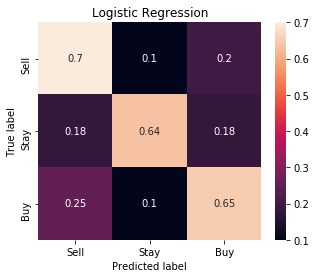

In [61]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred3)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Sell' , 'Stay', 'Buy'], 
                     columns = ['Sell' , 'Stay', 'Buy'])
plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('Logistic Regression')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [62]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = clf, X = X_train2, y = y_train2, cv = 5)
lg_cv = accuracies.mean()
accuracies.mean()
#cross validation accuracy score

0.35623023402909554

In [63]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(X_train2,y_train2)
y_pred4 = model.predict(X_test2)
#implementing RandomForestClassifier moddel with confusion matrix and other measures
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
rf_acc = metrics.accuracy_score(y_test2, y_pred4)
print(confusion_matrix(y_test2,y_pred4))  
print(classification_report(y_test2,y_pred4))  

[[4 3 3]
 [1 4 6]
 [7 6 7]]
             precision    recall  f1-score   support

       -1.0       0.33      0.40      0.36        10
        0.0       0.31      0.36      0.33        11
        1.0       0.44      0.35      0.39        20

avg / total       0.38      0.37      0.37        41



Text(0.5,15,'Predicted label')

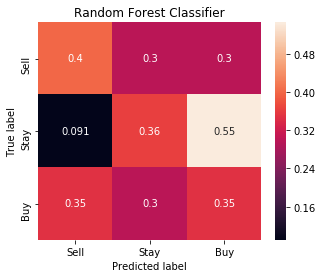

In [64]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred4)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Sell' , 'Stay', 'Buy'], 
                     columns = ['Sell' , 'Stay', 'Buy'])

plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('Random Forest Classifier')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [65]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = model, X = X_train2, y = y_train2, cv = 5)
rf_cv = accuracies.mean()
accuracies.mean()

0.41123569662469095

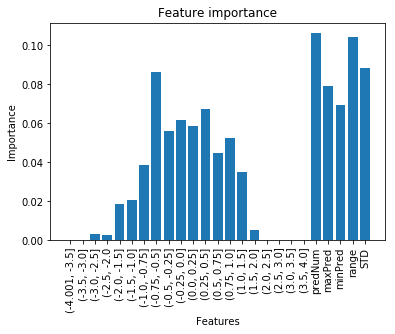

In [66]:
feature = model.feature_importances_
plt.bar(range(len(feature)), feature, align='center')
plt.xticks(range(len(feature)), featureCols, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()
#shows on bar graph all features and which is the most important

In [67]:
from sklearn import tree
tree = tree.DecisionTreeClassifier()
tree = tree.fit(X_train2,y_train2)
y_pred5 = tree.predict(X_test2)
#implementing decision tree moddel with confusion matrix and other measures

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import metrics
dt_acc = metrics.accuracy_score(y_test2, y_pred5)
print(confusion_matrix(y_test2,y_pred5))  
print(classification_report(y_test2,y_pred5))  

[[ 5  3  2]
 [ 1  4  6]
 [ 4  6 10]]
             precision    recall  f1-score   support

       -1.0       0.50      0.50      0.50        10
        0.0       0.31      0.36      0.33        11
        1.0       0.56      0.50      0.53        20

avg / total       0.48      0.46      0.47        41



Text(0.5,15,'Predicted label')

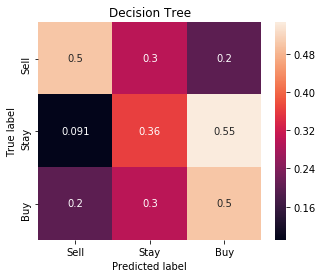

In [68]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred5)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Sell' , 'Stay', 'Buy'], 
                     columns = ['Sell' , 'Stay', 'Buy'])
plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('Decision Tree')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [69]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = tree, X = X_train2, y = y_train2, cv = 5)
dt_cv = accuracies.mean()
accuracies.mean()

0.35302742797998965

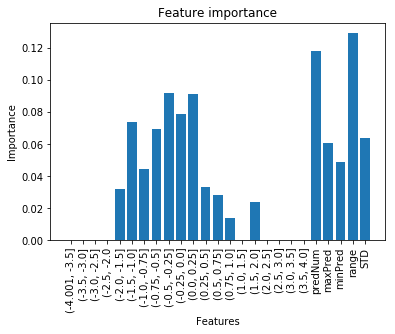

In [70]:
feature2 = tree.feature_importances_
plt.bar(range(len(feature2)), feature2, align='center')
plt.xticks(range(len(feature2)), featureCols, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()
#shows on bar graph all features and which is the most important

In [71]:
from sklearn.svm import SVC
svm= SVC()
#import of svm model with rbf kernel

In [72]:
%%time
svm.fit(X_train2, y_train2)

Wall time: 2.99 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = svm, X = X_train2, y = y_train2, cv = 5)
svm_cv = accuracies.mean()
accuracies.mean()

0.4421424874935311

In [74]:
y_pred2 = svm.predict(X_test2)

In [75]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import metrics
svm_acc = metrics.accuracy_score(y_test2, y_pred2)
print(confusion_matrix(y_test2,y_pred2))  
print(classification_report(y_test2,y_pred2))  
#classiication report and confussion matrix

[[ 0  1  9]
 [ 0  1 10]
 [ 0  0 20]]
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00        10
        0.0       0.50      0.09      0.15        11
        1.0       0.51      1.00      0.68        20

avg / total       0.38      0.51      0.37        41



C:\Users\maste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,15,'Predicted label')

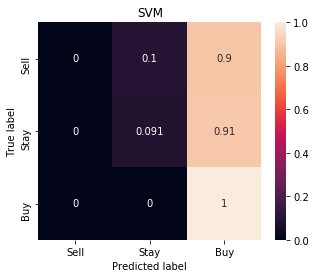

In [76]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred2)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Sell' , 'Stay', 'Buy'], 
                     columns = ['Sell' , 'Stay', 'Buy'])

plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('SVM')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

Text(0.5,1,'Model Accuracy')

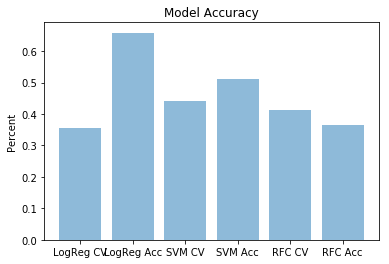

In [78]:
objects = ('LogReg CV','LogReg Acc', 'SVM CV', 'SVM Acc','RFC CV','RFC Acc')
y_pos = np.arange(len(objects))
accuracy = [lg_cv, lg_acc, svm_cv, svm_acc, rf_cv, rf_acc]
plt.bar(y_pos, accuracy, align='center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percent')
plt.title('Model Accuracy')